In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import time
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# load the dataset
data = pd.read_csv("./data_banknote_authentication.txt", header=None)
m, n = data.shape
# split into input and output columns
X, Y = data.values[:, :-1], data.values[:, -1] #separate data into input and output features
# ensure all data are floating point values
X = X.astype('float32')
Y = LabelEncoder().fit_transform(Y)
# split into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) #split data into train and test sets in 80-20 ratio
# determine the number of input features
n_features = X.shape[1]

X_train = X_train.T
X_test = X_test.T

In [3]:
def relu(Z):
    return np.maximum(Z, 0)

def tanh_deriv(Z):
    return 1-np.tanh(Z)**2

def sigmoid_deriv(Z):
    sig = 1/(1+np.exp(-Z))
    return sig * (1 - sig)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def relu_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [4]:
class NeuralNetwork:
    def __init__(self, layer_sizes, epochs, alpha, activations):
            self.layer_sizes = layer_sizes
            self.num_iters = epochs
            self.learning_rate = alpha
            self.activations = activations
            self.params = {}
            self.last = len(self.layer_sizes)
            self.init_params()
            self.accuracy = None
            self.X = None
            self.Y = None
            self.AccuracyList = []
            self.AccuracyEpochList = []
            self.AccuracyTimeList = []
            self.totalTime = None
            self.startTime = None
            self.stopTime = None
            
    def __repr__(self):
        return f"ANN Hyperparameters\nLayers: {self.layers_sizes}\nLearning rate: {self.learning_rate} \
        \nIterations: {self.num_iters}"
    

    def init_params(self):
        # Initalize the network with random weights and biases 
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i-1]) - 0.5
            params[f'B{i}'] = np.random.rand(self.layer_sizes[i],1) - 0.5
            
    def forward_propagation(self, X):
        # Pass X through the network 
        params = self.params
        for i in range(1, self.last):
            if i==1:
                # For first layer compute dot with x
                output = params[f'W{i}'].dot(X) + params[f'B{i}']
            else: 
                # For all other layers compute with output of prev layer
                output = params[f'W{i}'].dot(params[f'A{i-1}']) + params[f'B{i}']
            if(i == self.last - 1):
                # For final layer use softmax
                activations = softmax(output)
            else:
                # For all other layers use the activ_fnc initalized in constructor
                activ_fnc = self.activations[i-1]
                activations = globals()[activ_fnc](output)
            
            params[f'Z{i}'] = output
            params[f'A{i}'] = activations


    def backward_propagation(self, X, Y):
        ohY = one_hot(Y)
        params = self.params
        
        for i in range(self.last - 1, 0, -1):
            if(i == self.last - 1):
                # For final layer calculate how wrong net is and compute gradients for weights and biases
                dZ =  params[f'A{i}'] - ohY
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            elif (i == 1):
                # For first layer compute the gradients for weights and biases with input of dataset
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(X.T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            else: 
                # For all other layers compute the gradients for weights and biases with the output of the prev layer
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)

    
    def update_params(self, alpha):
        # Update all layers based on the gradients calculated in back prop
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] =  params[f'W{i}'] - self.learning_rate * params[f'dW{i}']
            params[f'B{i}'] =  params[f'B{i}'] - self.learning_rate * params[f'dB{i}']

    def make_predictions(self, X):
        self.forward_propagation(X)
        predictions = self.get_predictions()
        return predictions

    def test_predictions(self, i):
        curr = X_train[:, i, None]
        print("label ", Y_train[i])
        print("predicted ", self.make_predictions(curr)[0])

    def get_predictions(self):
        return np.argmax(self.params[f'A{self.last-1}'], 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def train(self, X, Y, printAccuracy=False):
        start = time.perf_counter()
        self.X = X
        self.Y = Y
        for i in range(self.num_iters):
            self.forward_propagation(X)
            self.backward_propagation(X, Y)
            self.update_params(self.learning_rate)
       
            predictions = self.get_predictions()
            self.accuracy = self.get_accuracy(predictions, Y)
            self.AccuracyList.append(self.accuracy)
            self.AccuracyEpochList.append((i,self.accuracy))
            self.AccuracyTimeList.append(((time.perf_counter() - start), self.accuracy))
            
            # Print accuracy every 10 iterations
            if(printAccuracy==True):
                if i % 10 == 0:
                    print("Iteration: ", i)
                    print('Accuracy: ', self.accuracy)
        stop = time.perf_counter()
        self.totalTime = stop - start
        self.startTime = start
        self.stopTime = stop
        return self.params
    
    def change_layers(self, layers):
        old_accuracy = self.accuracy
        self.layer_sizes = layers
        self.init_params()
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
        
    def change_activations(self, activations):
        old_accuracy = self.accuracy
        self.activations = activations
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
    
    def change_epochs(self, epochs):
        old_accuracy = self.accuracy
        self.num_iters = epochs
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
    
    def change_learningRate(self, alpha):
        old_accuracy = self.accuracy
        self.learning_rate = alpha
        self.train(self.X, self.Y, printAccuracy=False)
        print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
        
    def view_accuracyEpoch(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyEpochList, columns=["Epochs", "Accuracy"])
        sns.lineplot(data=df, x="Epochs", y="Accuracy", ci=None)
    
    def view_accEpoch(self):
        df = pd.DataFrame(self.AccuracyEpochList, columns=["Epochs", "Accuracy"])
        fig = px.line(df, x="Epochs", y="Accuracy", title="Accuracy vs Epochs")
        fig.show()
    
    def view_accTime(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyTimeList, columns=["Time", "Accuracy"])
        sns.lineplot(data=df, x="Time", y="Accuracy", ci=None)
        
    

In [5]:
nn = NeuralNetwork([4,10,10,2], 500, 0.10, ['relu','relu'])

In [6]:
x = nn.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.22306855277475518
Iteration:  10
Accuracy:  0.6920565832426551
Iteration:  20
Accuracy:  0.7627856365614799
Iteration:  30
Accuracy:  0.8509249183895539
Iteration:  40
Accuracy:  0.8879216539717084
Iteration:  50
Accuracy:  0.9249183895538629
Iteration:  60
Accuracy:  0.9445048966267682
Iteration:  70
Accuracy:  0.970620239390642
Iteration:  80
Accuracy:  0.9771490750816104
Iteration:  90
Accuracy:  0.984766050054407
Iteration:  100
Accuracy:  0.984766050054407
Iteration:  110
Accuracy:  0.984766050054407
Iteration:  120
Accuracy:  0.9869423286180631
Iteration:  130
Accuracy:  0.9869423286180631
Iteration:  140
Accuracy:  0.9880304678998912
Iteration:  150
Accuracy:  0.9912948857453754
Iteration:  160
Accuracy:  0.9912948857453754
Iteration:  170
Accuracy:  0.9912948857453754
Iteration:  180
Accuracy:  0.9912948857453754
Iteration:  190
Accuracy:  0.9912948857453754
Iteration:  200
Accuracy:  0.9945593035908596
Iteration:  210
Accuracy:  0.9967355821545157
It

In [7]:
preds = nn.make_predictions(X_test)

In [8]:
nn.test_predictions(1)

label  1
predicted  1


In [9]:
n

5

In [10]:
nn.change_layers([4,16,16,2])

Old test accuracy: 1.0
New test accuracy: 1.0


In [11]:
nn.change_activations(['sigmoid', 'sigmoid'])

Old test accuracy: 1.0
New test accuracy: 0.9912948857453754


In [12]:
nn.change_epochs(100)

Old test accuracy: 0.9912948857453754
New test accuracy: 0.9923830250272034


In [13]:
nn.change_learningRate(0.05)

Old test accuracy: 0.9923830250272034
New test accuracy: 0.9923830250272034


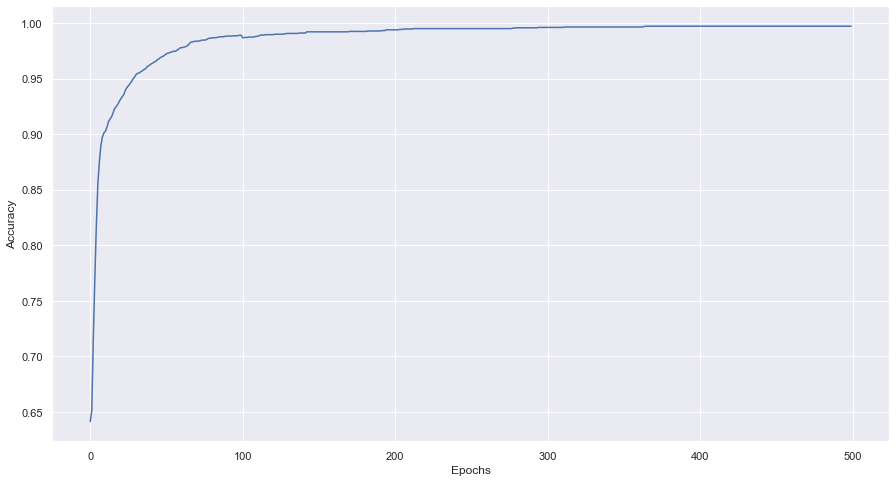

In [14]:
nn.view_accuracyEpoch()

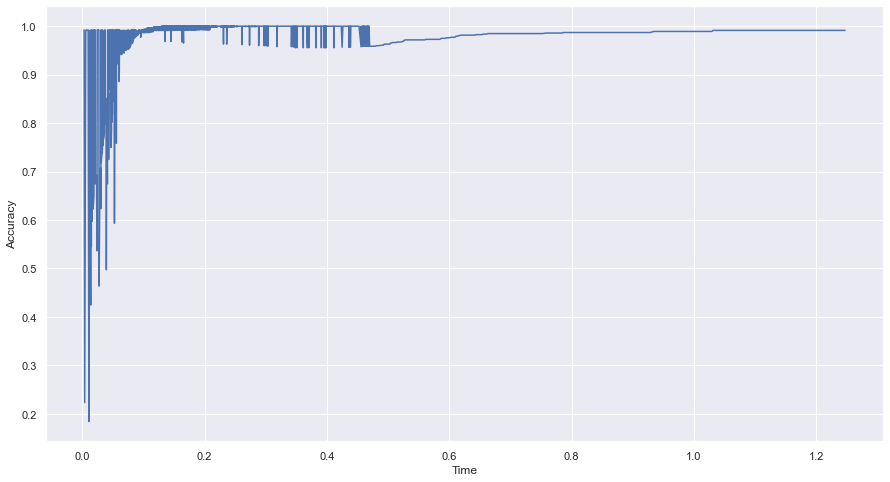

In [15]:
nn.view_accTime()

In [16]:
nn.totalTime

0.18552204800000016

In [17]:
nn.AccuracyTimeList

[(0.004078717000000065, 0.22306855277475518),
 (0.01095759999999979, 0.1838955386289445),
 (0.013914678999999985, 0.4243743199129489),
 (0.01493370099999991, 0.545157780195865),
 (0.016338819000000004, 0.5973884657236126),
 (0.017776373999999873, 0.6224156692056583),
 (0.01918802399999997, 0.6496191512513602),
 (0.021425291999999985, 0.6746463547334058),
 (0.022257334999999934, 0.6844396082698585),
 (0.02286483100000014, 0.6866158868335147),
 (0.023435391000000028, 0.6920565832426551),
 (0.029056638999999773, 0.7007616974972797),
 (0.030027400999999898, 0.7072905331882481),
 (0.03058372500000006, 0.7127312295973884),
 (0.031090299999999793, 0.7181719260065288),
 (0.03159199300000015, 0.7279651795429815),
 (0.03209301699999978, 0.73449401523395),
 (0.032604736000000134, 0.7366702937976061),
 (0.03310548400000002, 0.7453754080522307),
 (0.03360605499999991, 0.7529923830250272),
 (0.03410494400000008, 0.7627856365614799),
 (0.03574564000000002, 0.7714907508161044),
 (0.03628654900000017, 